# 2CNN
# 4-Higgs Classifier

In [1]:
#!/usr/bin/env python
# encoding: utf-8
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers
from tensorflow.keras.models import Model


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
# from xgboost import XGBClassifier
import tensorflow.keras.backend as K
from sklearn import metrics

# Import local libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import importlib

import csv_decoder
import save_and_load


print("Tensorflow Version is {}".format(tf.__version__))
print("Keras Version is {}".format(tf.keras.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.device('/device:XLA_GPU:0')
!nvidia-smi

1 Physical GPUs, 1 Logical GPU
Tensorflow Version is 2.0.0
Keras Version is 2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15101871471930563281
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11222727553886953546
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 12582912000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 95117970514402441
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:03:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6630718996348957411
physical_device_desc: "device: XLA_GPU device"
]
Wed Jun 17 01:18:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------

### Some functions will be in the training

In [2]:
#FUNCTIONS FOR ML

#FRANK# returns a function that generates a padding layer
#FRANK# x is the detector image, of following format:
#FRANK# [index, image#(charged and neutral pt and multiplicity), 40, 40]
def return_pad_me(padding):
    def pad_me(x):
        #FRANK# x[:,:,:y,:] slice x off from y at the given axis.
        return(tf.concat((x,x[:,:,:padding,:]),2))
#         return(tf.concat((2,x,x[:,:,:padding,:])))
    return(pad_me)

def pad_out(padding,input_shape):
    return input_shape

class gen_call(keras.callbacks.Callback):
    
    def __init__(self, test_data):
        self.x, self.y = test_data
    
    def on_train_begin(self,logs={}):
        self.highest_SIC_train = []
        self.highest_SIC_test = []
        
    def on_epoch_end(self,epoch,logs={}):
        y_pred = self.model.predict(self.x)
        self.highest_SIC_test.append(find_highest_SIC(self.y,y_pred))
        print(str(self.highest_SIC_test[-1]) + " is how good")

def show_outputs(output):
    #Assumes the output is in shape like (32,41,36)
    
    fig = plt.figure(figsize=(8,6))
    
    for i in range(1,1+output.shape[0]):
        fig.add_subplot(4,output.shape[0]/4,i)
        plt.imshow(10*output[i-1,:,:])
        plt.axis('off')
    #plt.axis('off')
    plt.show()
    
    
#FRANK# this method is the exact replica of find_highest_SIC() but operates on tensors.
#FRANK# for some reason, pred has different format as expect. 
def highest_SIC_metric(y_true,y_pred):
    print('highest_SIC_metric() is called')
    y_true = tf.keras.backend.flatten(y_true) #FRANK# flattens to 1D
    y_pred = tf.keras.backend.flatten(y_pred) #FRANK# flattens to 1D
    
    #stacked = tf.transpose(tf.stack((expect,predict)))
    #to_sort = tf.reverse(sorted(stacked, key=lambda x: x[1]),0) #FRANK# sorted is wrong!!
    total_sample = tf.cast(tf.size(y_pred), tf.float32)  # count total nums, then cast to float32 to avoid issue
    total_signal = tf.cast(tf.reduce_sum(y_true), tf.float32)  # summing across all predicted (where sigs are 1's and bkgs are 0's) to get total num of signal. 
    total_background = tf.cast(tf.subtract(total_sample, total_signal), tf.float32)  # subtracting signal countss from total size to get background counts
    
    
    # original mechanism:
    # 1. sort by ML score
    # 2. sum all actuals before an index
    # 3. count all 0's before an index 
    
    sorted_indices = tf.argsort(y_pred,axis=-1,direction='ASCENDING')
    sorted_sigs = tf.gather(y_pred,sorted_indices)
    # return the indices of prediction in ascending order. By reading these indices, you can access corresponding expected y's.
    ones = tf.fill(tf.shape(sorted_sigs), 1.0)
    sorted_bkgs = tf.subtract(ones, sorted_sigs)
    # make a sorted tensor where 1's are bkgs and 0's are sigs
    
    sig_cum_sums = tf.cast(tf.cumsum(sorted_sigs), tf.float32) # return the integrated signal number from 0 to each index
    bkg_cum_sums = tf.cast(tf.cumsum(sorted_bkgs), tf.float32) # return the integrated bkg number from 0 to each index

    sig_effs = tf.divide(sig_cum_sums, total_signal)
    bkg_effs = tf.divide(bkg_cum_sums, total_background) #FRANK# total_background might be 0, causing bkg_effs=inf
    effs = tf.divide(sig_effs, tf.sqrt(bkg_effs))
        
    return tf.reduce_max(effs)

### Load from Numpy

In [4]:
importlib.reload(save_and_load)
# time counter
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
############################################################################################################################################################
# save_and_load.load(folder_name, process_name)
path = "/u4/alan/higgs_numpyfile/"
# ggh_event_list,ggh_mass_list, ggh_higgs_list, ggh_weight_list,ggh_image_list, ggh_recluster_images = save_and_load.load_numpy(path+"numpy_file_3","ggH")
# vbf_event_list,vbf_mass_list, vbf_higgs_list, vbf_weight_list, vbf_image_list, vbf_recluster_images = save_and_load.load_numpy(path+"numpy_file_3","VBF")
# vh_event_list,vh_mass_list, vh_higgs_list, vh_weight_list, vh_image_list, vh_recluster_images = save_and_load.load_numpy(path+"numpy_file_3","VH")
# tth_event_list,tth_mass_list, tth_higgs_list, tth_weight_list, tth_image_list, tth_recluster_images = save_and_load.load_numpy(path+"numpy_file_3","ttH")

_,_, _, _,ggh_image_list, ggh_recluster_images = save_and_load.load_numpy(path+"numpy_file_3","ggH")
_,_, _, _, vbf_image_list, vbf_recluster_images = save_and_load.load_numpy(path+"numpy_file_3","VBF")
_,_, _, _, vh_image_list, vh_recluster_images = save_and_load.load_numpy(path+"numpy_file_3","VH")
_,_, _, _, tth_image_list, tth_recluster_images = save_and_load.load_numpy(path+"numpy_file_3","ttH")


############################################################################################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

Sun Jun 14 22:37:39 2020
Time Cost : 32.3564 min


In [5]:
print("{:^44}".format("w/ decay and preselection "))
print("{:^20} {:^6} {:^6} {:^6} {:^6}".format("","ggH","VBF","VH","ttH"))
print("{:^20} {:^6} {:^6} {:^6} {:^6}".format("# of event ",len(ggh_image_list),len(vbf_image_list),len(vh_image_list),len(tth_image_list)))


         w/ decay and preselection          
                      ggH    VBF     VH    ttH  
    # of event       228705 375024 280942 259481


## We can easily to choose the event and let them to be same as BDT

In [6]:
Train_data_file_path = './BDT_Model/Data_train.csv'
Test_data_file_path = './BDT_Model/Data_test.csv'
Val_data_file_path = './BDT_Model/Data_val.csv'
# read the data and store data in DataFrame
Data_train = pd.read_csv(Train_data_file_path)
Data_test = pd.read_csv(Test_data_file_path)
Data_val = pd.read_csv(Val_data_file_path)

list = ["higgs_pt","higgs_eta","higgs_m",
           "non_higgs_leading_pt","non_higgs_leading_eta","non_higgs_leading_m",
           "non_higgs_second_pt","non_higgs_second_eta","non_higgs_second_m",
           "girth","CIJS","SIJS","DeltaEta",
            "weight","isHJ","isVBF","isVH","eventindex","prediction"]

Data_train["PTH"],Data_train["evtweight"] = Data_train["higgs_pt"],Data_train["weight"]
Data_test["PTH"],Data_test["evtweight"] = Data_test["higgs_pt"],Data_test["weight"]
Data_val["PTH"],Data_val["evtweight"] = Data_val["higgs_pt"],Data_val["weight"]

ggH_train = Data_train[Data_train["isGGH"]==1]
VBF_train = Data_train[Data_train["isVBF"]==1]
VH_train = Data_train[Data_train["isVH"]==1]
ttH_train = Data_train[Data_train["isttH"]==1]

ggH_test = Data_test[Data_test["isGGH"]==1]
VBF_test = Data_test[Data_test["isVBF"]==1]
VH_test = Data_test[Data_test["isVH"]==1]
ttH_test = Data_test[Data_test["isttH"]==1]

ggH_val = Data_val[Data_val["isGGH"]==1]
VBF_val = Data_val[Data_val["isVBF"]==1]
VH_val = Data_val[Data_val["isVH"]==1]
ttH_val = Data_val[Data_val["isttH"]==1]

In [ ]:
ggh_image_train, ggh_jet_train = ggh_image_list[ggH_train["eventindex"]], ggh_recluster_images[ggH_train["eventindex"]]
ggh_image_test, ggh_jet_test = ggh_image_list[ggH_test["eventindex"]], ggh_recluster_images[ggH_test["eventindex"]]
ggh_image_val, ggh_jet_val = ggh_image_list[ggH_val["eventindex"]], ggh_recluster_images[ggH_val["eventindex"]]

vbf_image_train, vbf_jet_train = vbf_image_list[VBF_train["eventindex"]], vbf_recluster_images[VBF_train["eventindex"]]
vbf_image_test, vbf_jet_test = vbf_image_list[VBF_test["eventindex"]], vbf_recluster_images[VBF_test["eventindex"]]
vbf_image_val, vbf_jet_val = vbf_image_list[VBF_val["eventindex"]], vbf_recluster_images[VBF_val["eventindex"]]

vh_image_train, vh_jet_train = vh_image_list[VH_train["eventindex"]], vh_recluster_images[VH_train["eventindex"]]
vh_image_test, vh_jet_test = vh_image_list[VH_test["eventindex"]], vh_recluster_images[VH_test["eventindex"]]
vh_image_val, vh_jet_val = vh_image_list[VH_val["eventindex"]], vh_recluster_images[VH_val["eventindex"]]

tth_image_train, tth_jet_train = tth_image_list[ttH_train["eventindex"]], tth_recluster_images[ttH_train["eventindex"]]
tth_image_test, tth_jet_test = tth_image_list[ttH_test["eventindex"]], tth_recluster_images[ttH_test["eventindex"]]
tth_image_val, tth_jet_val = tth_image_list[ttH_val["eventindex"]], tth_recluster_images[ttH_val["eventindex"]]



print("ggH Training: Event Image {}, Jet Image {} ".format(ggh_image_train.shape,ggh_jet_train.shape))
print("ggH Test: Event Image {}, Jet Image {} ".format(ggh_image_test.shape,ggh_jet_test.shape))
print("ggH Val.: Event Image {}, Jet Image {} ".format(ggh_image_val.shape,ggh_jet_val.shape))
print("VBF Training: Event Image {}, Jet Image {} ".format(vbf_image_train.shape,vbf_jet_train.shape))
print("VBF Test: Event Image {}, Jet Image {} ".format(vbf_image_test.shape,vbf_jet_test.shape))
print("VBF Val.: Event Image {}, Jet Image {} ".format(vbf_image_val.shape,vbf_jet_val.shape))
print("VH Training: Event Image {}, Jet Image {} ".format(vh_image_train.shape,vh_jet_train.shape))
print("VH Test: Event Image {}, Jet Image {} ".format(vh_image_test.shape,vh_jet_test.shape))
print("VH Val.: Event Image {}, Jet Image {} ".format(vh_image_val.shape,vh_jet_val.shape))
print("ttH Training: Event Image {}, Jet Image {} ".format(tth_image_train.shape,tth_jet_train.shape))
print("ttH Test: Event Image {}, Jet Image {} ".format(tth_image_test.shape,tth_jet_test.shape))
print("ttH Val.: Event Image {}, Jet Image {} ".format(tth_image_val.shape,tth_jet_val.shape))

In [7]:
x_train_eve = np.concatenate((ggh_image_train, vbf_image_train))
x_train_eve = np.concatenate((x_train_eve, vh_image_train))
x_train_eve = np.concatenate((x_train_eve, tth_image_train))
x_test_eve = np.concatenate((ggh_image_test, vbf_image_test))
x_test_eve = np.concatenate((x_test_eve, vh_image_test))
x_test_eve = np.concatenate((x_test_eve, tth_image_test))
x_val_eve = np.concatenate((ggh_image_val, vbf_image_val))
x_val_eve = np.concatenate((x_val_eve, vh_image_val))
x_val_eve = np.concatenate((x_val_eve, tth_image_val))

x_train_jet = np.concatenate((ggh_jet_train, vbf_jet_train))
x_train_jet = np.concatenate((x_train_jet, vh_jet_train))
x_train_jet = np.concatenate((x_train_jet, tth_jet_train))
x_test_jet = np.concatenate((ggh_jet_test, vbf_jet_test))
x_test_jet = np.concatenate((x_test_jet, vh_jet_test))
x_test_jet = np.concatenate((x_test_jet, tth_jet_test))
x_val_jet = np.concatenate((ggh_jet_val, vbf_jet_val))
x_val_jet = np.concatenate((x_val_jet, vh_jet_val))
x_val_jet = np.concatenate((x_val_jet, tth_jet_val))

# sample_weight = np.concatenate((ggh_weight_list[HJ_train["eventindex"]], vbf_weight_list[VBF_train["eventindex"]]))
# sample_weight = np.concatenate((sample_weight,vh_weight_list[VH_train["eventindex"]]))

y_train = np.concatenate((np.full(len(ggh_image_train), 0), np.full(len(vbf_image_train), 1)))
y_train = np.concatenate((y_train, np.full(len(vh_image_train), 2)))
y_train = np.concatenate((y_train, np.full(len(tth_image_train), 3)))
y_test = np.concatenate((np.full(len(ggh_image_test), 0), np.full(len(vbf_image_test), 1)))
y_test = np.concatenate((y_test, np.full(len(vh_image_test), 2)))
y_test = np.concatenate((y_test, np.full(len(tth_image_test), 3)))
y_val = np.concatenate((np.full(len(ggh_image_val), 0), np.full(len(vbf_image_val), 1)))
y_val = np.concatenate((y_val, np.full(len(vh_image_val), 2)))
y_val = np.concatenate((y_val, np.full(len(tth_image_val), 3)))

print("Event: Training {} Test {} Val {}".format(x_train_eve.shape,x_test_eve.shape,x_val_eve.shape))
print("Jet: Training {} Test {} Val {}".format(x_train_jet.shape,x_test_jet.shape,x_val_jet.shape))
print("Target: Training {} Test {} Val {}".format(y_train.shape,y_test.shape,y_val.shape))
input_shape = x_train_eve[0].shape

y_train_origin = y_train
y_test_origin = y_test
y_val_origin = y_val
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)



# Just Load Event Here

In [3]:
# time counter
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
############################################################################################################################################################
# filepath = "/u2/alan-2/higgsproduction/"
filepath = "/u4/alan/higgs/"

# np.save(filepath+"2CNN_Data/x_train_eve",x_train_eve)
# np.save(filepath+"2CNN_Data/x_test_eve",x_test_eve)
# np.save(filepath+"2CNN_Data/x_val_eve",x_val_eve)
# np.save(filepath+"2CNN_Data/x_train_jet",x_train_jet)
# np.save(filepath+"2CNN_Data/x_test_jet",x_test_jet)
# np.save(filepath+"2CNN_Data/x_val_jet",x_val_jet)

# np.save(filepath+"2CNN_Data/y_train",y_train)
# np.save(filepath+"2CNN_Data/y_test",y_test)
# np.save(filepath+"2CNN_Data/y_val",y_val)

# import gc 
# gc.collect()




x_train_eve = np.load(filepath + "2CNN_Data/x_train_eve.npy")
x_test_eve = np.load(filepath + "2CNN_Data/x_test_eve.npy")
x_val_eve = np.load(filepath + "2CNN_Data/x_val_eve.npy")
x_train_jet = np.load(filepath + "2CNN_Data/x_train_jet.npy")
x_test_jet = np.load(filepath + "2CNN_Data/x_test_jet.npy")
x_val_jet = np.load(filepath + "2CNN_Data/x_val_jet.npy")
y_train = np.load(filepath + "2CNN_Data/y_train.npy") #already one-hot-code
y_test = np.load(filepath + "2CNN_Data/y_test.npy")  #already one-hot-code
y_val = np.load(filepath + "2CNN_Data/y_val.npy")  #already one-hot-code

############################################################################################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

Sun May 24 23:37:45 2020
Time Cost : 17.1848 min


In [4]:
import os
import psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss/1024./1024./1024.," GB")

43.364776611328125  GB


### Splitting data (Previous Version) (No Longer Used)

In [17]:
# # Function that splits whole event dataset into test, train and evaluation sets.
# # the *_cut outputs has a 115<mass<135 cut.
# rsplit = np.array([0.5,0.75])

# def split_data(background_image_list,signal_image_list,background_mass_list, signal_mass_list, cut=False):
#     try:
#         input_shape = background_image_list[0].shape
#     except AttributeError:
#         input_shape = (0)
        
#     b_split = np.split(background_image_list,(len(background_image_list)*rsplit).astype(int))
# #     print(len(b_split))
#     s_split = np.split(signal_image_list,(len(signal_image_list)*rsplit).astype(int))
#     bm_split = np.split(background_mass_list,(len(background_mass_list)*rsplit).astype(int))
#     sm_split = np.split(signal_mass_list,(len(signal_mass_list)*rsplit).astype(int))
    
#     x_train = np.concatenate((b_split[0],s_split[0]))
#     y_train = np.array(np.concatenate((np.zeros(len(b_split[0])),np.ones(len(s_split[0])))))
#     mass_train = np.concatenate((bm_split[0],sm_split[0]))
    
#     x_val = np.concatenate((b_split[1],s_split[1]))
#     y_val = np.array(np.concatenate((np.zeros(len(b_split[1])),np.ones(len(s_split[1])))))
#     mass_val = np.concatenate((bm_split[1],sm_split[1]))
    
#     x_test = np.concatenate((b_split[2],s_split[2]))
#     y_test = np.array(np.concatenate((np.zeros(len(b_split[2])),np.ones(len(s_split[2])))))
#     mass_test = np.concatenate((bm_split[2],sm_split[2]))
    
#     # Output dataset with mass cut
#     if cut:
#         x_train_cut = []
#         y_train_cut = []
#         mass_train_cut = []
#         for x in reversed(range(len(x_train))):
#             if mass_train[x] < 135 and mass_train[x] > 115:
#                 x_train_cut.append(x_train[x])
#                 y_train_cut.append(y_train[x])
#                 mass_train_cut.append(mass_train[x])
#         x_train_cut = np.array(x_train_cut)
#         y_train_cut = np.array(y_train_cut)
#         mass_train_cut = np.array(mass_train_cut)

#         x_val_cut = [] 
#         y_val_cut = []
#         mass_val_cut = []
#         for x in reversed(range(len(x_val))):
#             if mass_val[x] < 135 and mass_val[x] > 115:
#                 x_val_cut.append(x_val[x])
#                 y_val_cut.append(y_val[x])
#                 mass_val_cut.append(mass_val[x])
#         x_val_cut = np.array(x_val_cut)
#         y_val_cut = np.array(y_val_cut)
#         mass_val_cut = np.array(mass_val_cut)

#         x_test_cut = [] 
#         y_test_cut = []
#         mass_test_cut = []
#         for x in reversed(range(len(x_test))):
#             if mass_test[x] < 135 and mass_test[x] > 115:
#                 x_test_cut.append(x_test[x])
#                 y_test_cut.append(y_test[x])
#                 mass_test_cut.append(mass_test[x])
#         x_test_cut = np.array(x_test_cut)
#         y_test_cut = np.array(y_test_cut)
#         mass_test_cut = np.array(mass_test_cut)
#         return(input_shape,
#                x_train_cut,y_train_cut,mass_train_cut,
#                x_val_cut,y_val_cut,mass_val_cut,
#                x_test_cut,y_test_cut,mass_test_cut,
#                )
#     return(input_shape,
#            x_train,y_train,mass_train,
#            x_val,y_val,mass_val,
#            x_test,y_test,mass_test,
#            )

In [ ]:
# input_shape, \
# x_train_eve,y_train,mass_train_eve, \
# x_val_eve,y_val,mass_val_eve, \
# x_test_eve,y_test,mass_test_eve = split_data(hj_image_list,vbf_image_list,hj_mass_list, vbf_mass_list)

# input_shape, \
# x_train_jet,y_train,mass_train_jet, \
# x_val_jet,y_val,mass_val_jet, \
# x_test_jet,y_test,mass_test_jet = split_data(hj_recluster_images,vbf_recluster_images,hj_mass_list, vbf_mass_list)

### For CPU
#### We need to reshape image from (3,40,40) to (40,40,3)

### For GPU
#### The image will be (3,40,40)

In [ ]:
# x_train_event = np.zeros((len(x_train_eve),40,40,3))
# x_val_event = np.zeros((len(x_val_eve),40,40,3))
# x_test_event = np.zeros((len(x_test_eve),40,40,3))

# for i in range(len(x_train_eve)):
#     x_train_event[i,:,:,0] = x_train_eve[i][0]
#     x_train_event[i,:,:,1] = x_train_eve[i][1]
#     x_train_event[i,:,:,2] = x_train_eve[i][2]

# for i in range(len(x_val_eve)):
#     x_val_event[i,:,:,0] = x_val[i][0]
#     x_val_event[i,:,:,1] = x_val[i][1]
#     x_val_event[i,:,:,2] = x_val[i][2]
    
# for i in range(len(x_test_eve)):
#     x_test_event[i,:,:,0] = x_test_eve[i][0]
#     x_test_event[i,:,:,1] = x_test_eve[i][1]
#     x_test_event[i,:,:,2] = x_test_eve[i][2]


# input_shape = (40, 40,3)

# print(len(x_train[0]))
# print(x_train[0,:,:,0].shape)

# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.imshow(x_train_eve[0,0,:,:])
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=10)
# plt.figure(figsize=(15,5))
# plt.subplot(1,3,1)
# plt.imshow(x_train_event[0,:,:,0])
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=10)

In [ ]:
x_train_jet_tmp = np.zeros((len(x_train_jet),40,40,3))
x_val_jet_tmp = np.zeros((len(x_val_jet),40,40,3))
x_test_jet_tmp = np.zeros((len(x_test_jet),40,40,3))

for i in range(len(x_train_jet)):
    x_train_jet_tmp[i,:,:,0] = x_train_jet[i][0]
    x_train_jet_tmp[i,:,:,1] = x_train_jet[i][1]
    x_train_jet_tmp[i,:,:,2] = x_train_jet[i][2]

for i in range(len(x_val_jet)):
    x_val_jet_tmp[i,:,:,0] = x_val_jet[i][0]
    x_val_jet_tmp[i,:,:,1] = x_val_jet[i][1]
    x_val_jet_tmp[i,:,:,2] = x_val_jet[i][2]
    
for i in range(len(x_test_jet)):
    x_test_jet_tmp[i,:,:,0] = x_test_jet[i][0]
    x_test_jet_tmp[i,:,:,1] = x_test_jet[i][1]
    x_test_jet_tmp[i,:,:,2] = x_test_jet[i][2]


input_shape = (40, 40,3)

print(len(x_train[0]))
print(x_train[0,:,:,0].shape)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(x_train_jet[0,0,:,:])
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(x_train_jet_tmp[0,:,:,0])
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

x_train_jet_tmp = x_train_jet
x_val_jet_tmp = x_val_jet
x_test_jet_tmp = x_test_jet

### CNN Network Structure for event image

In [19]:
#FINAL - This is the convolutional net for the event image
model_event = Sequential(name = 'Sequential_for_event')
model_event.add(Lambda(return_pad_me(4),input_shape=input_shape))
model_event.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 data_format='channels_first'))
model_event.add(Lambda(return_pad_me(1),input_shape=input_shape))
model_event.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),data_format='channels_first'))
model_event.add(Lambda(return_pad_me(4),input_shape=input_shape))
model_event.add(Conv2D(64, (5, 5),activation='relu',data_format="channels_first"))
model_event.add(Lambda(return_pad_me(1),input_shape=input_shape))
model_event.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_first"))
model_event.add(Flatten())
model_event.add(Dense(1000, activation='relu'))
# model_event.add(Dense(1, activation='sigmoid'))
model_event.add(Dense(3, activation='softmax'))
model_event.summary()

#model_opt = keras.optimizers.Adadelta(lr=2.0, rho=0.95, epsilon=None, decay=0.0)
model_opt = keras.optimizers.Adadelta() #FRANK# decrease learning rate


model_event.compile(loss="categorical_crossentropy",  #keras.losses.binary_crossentropy,
              optimizer=model_opt,
              metrics=['accuracy'])#, highest_SIC_metric])

Model: "Sequential_for_event"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 3, 44, 40)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 40, 36)        2432      
_________________________________________________________________
lambda_9 (Lambda)            (None, 32, 41, 36)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 20, 18)        0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 32, 24, 18)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 20, 14)        51264     
_________________________________________________________________
lambda_11 (Lambda)           (None, 64, 21, 14

In [20]:
# time counter
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
############################################################################################################################################################

epochs = 30
history_event_only = model_event.fit(x_train_eve, y_train,
        batch_size=512,#batch_size,
        epochs=epochs,
        validation_data=(x_test_eve,y_test),
        verbose=1, shuffle=True)#, callbacks=[EarlyStopping(monitor='highest_SIC_test', patience=2)])

############################################################################################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

Thu Apr 16 19:31:56 2020
Train on 90000 samples, validate on 30000 samples
Epoch 1/30
90000/90000 [==============================] - 6s 66us/sample - loss: 1.1148 - accuracy: 0.3663 - val_loss: 1.0926 - val_accuracy: 0.3879
Epoch 2/30
90000/90000 [==============================] - 4s 50us/sample - loss: 1.0782 - accuracy: 0.4117 - val_loss: 1.0675 - val_accuracy: 0.4309
Epoch 3/30
90000/90000 [==============================] - 4s 50us/sample - loss: 1.0586 - accuracy: 0.4397 - val_loss: 1.0518 - val_accuracy: 0.4515
Epoch 4/30
90000/90000 [==============================] - 4s 50us/sample - loss: 1.0448 - accuracy: 0.4588 - val_loss: 1.0399 - val_accuracy: 0.4645
Epoch 5/30
90000/90000 [==============================] - 5s 51us/sample - loss: 1.0337 - accuracy: 0.4735 - val_loss: 1.0301 - val_accuracy: 0.4779
Epoch 6/30
90000/90000 [==============================] - 4s 49us/sample - loss: 1.0242 - accuracy: 0.4852 - val_loss: 1.0212 - val_accuracy: 0.4875
Epoch 7/30
90000/90000 [=======

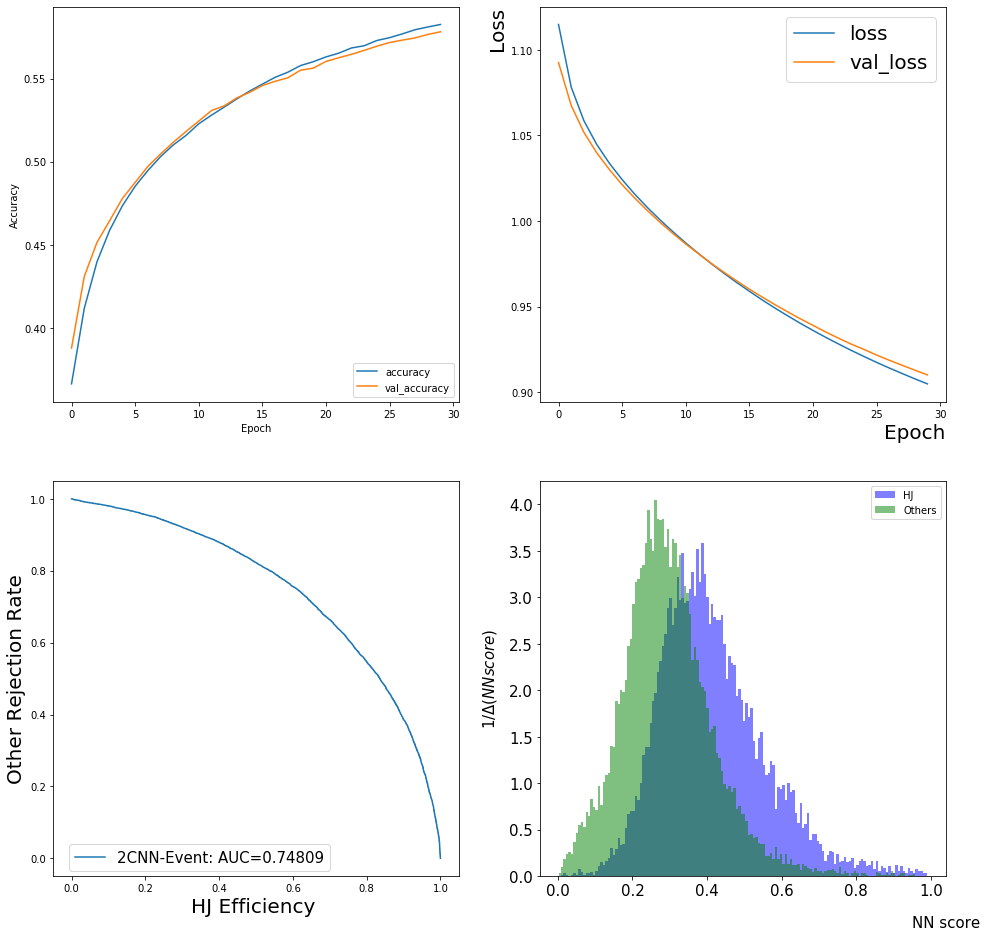

loss: 0.91009
accuracy: 0.57817


In [22]:
axis = 0
if axis == 0:
    process = "HJ"
elif axis == 1:
    process = "VBF"
elif axis == 2:
    process = "VH"
    
prediction = model_event.predict(x_test_eve)

test_auc = metrics.roc_auc_score(y_test[:,axis],prediction[:,axis])

FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test[:,axis],prediction[:,axis])

plt.figure(figsize=(16,16))
plt.subplot(2,2,1)

plt.plot(history_event_only.history['accuracy'], label='accuracy')
plt.plot(history_event_only.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.subplot(2,2,2)
plt.plot(history_event_only.history['loss'], label='loss')
plt.plot(history_event_only.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch', fontsize=20, horizontalalignment='right',x=1)
plt.ylabel('Loss', fontsize=20, horizontalalignment='right',y=1)
# plt.ylim([0.5, 1])
plt.legend(fontsize=20)#,loc='lower right')

plt.subplot(2,2,3)
plt.plot(TruePositiveFull,1-FalsePositiveFull, label='2CNN-Event: AUC={0:.5f}'.format(test_auc))

plt.ylabel('Other Rejection Rate',fontsize=20)
plt.xlabel(str(process)+' Efficiency ',fontsize=20)
plt.legend(bbox_to_anchor=(0.7, 0.1),ncol=1,fontsize=15)
# plt.tight_layout()

plt.subplot(2,2,4)
Data = pd.DataFrame()
Data["target"] = y_test[:,axis]
Data["pre"] = prediction[:,axis]
inner = Data[Data["target"]==1]
outter = Data[Data["target"]==0]
NNscoreplot = pd.DataFrame({str(process): inner["pre"], 'Others': outter["pre"]}, columns=[str(process), 'Others'])
plot = NNscoreplot.plot( kind = 'hist', title = "", legend = True, bins = 150, alpha=0.5,
                      color=['b','g'],stacked=False,density=1,fontsize=15,ax=plt.gca())

plot.set_ylabel("$1/\Delta (NN score)$",fontsize=15)
plot.set_xlabel("NN score",fontsize=15)
plot.xaxis.set_label_coords(1, -0.1)
plot.yaxis.set_label_coords(-0.1 , 0.5)

# plt.savefig("./Higgs_Pt/ROC", transparent=True)
plt.show()

aaaa = model_event.evaluate(x_test_eve,  y_test, verbose=0)
print("{}: {:.5f}".format(model_event.metrics_names[0],aaaa[0]))
print("{}: {:.5f}".format(model_event.metrics_names[1],aaaa[1]))
# print("{}: {:.5f}".format(model_event.metrics_names[2],aaaa[2])) 

### CNN Network Structure for jet image

In [23]:
model_jet = Sequential(name = 'Sequential_for_jet')
model_jet.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                data_format='channels_first',input_shape=input_shape))
model_jet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),data_format='channels_first'))
model_jet.add(Conv2D(64, (5, 5), activation='relu',data_format='channels_first'))
model_jet.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))
model_jet.add(Flatten())
model_jet.add(Dense(1000, activation='relu'))
# model_jet.add(Dense(1, activation='sigmoid'))
model_jet.add(Dense(3, activation='softmax'))

model_opt = keras.optimizers.Adadelta()

model_jet.compile(loss="categorical_crossentropy" ,#keras.losses.binary_crossentropy,
              optimizer=model_opt,
              metrics=['accuracy'])
model_jet.summary()

Model: "Sequential_for_jet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 36, 36)        2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 18, 18)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 14, 14)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 7, 7)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              3137000   
_________________________________________________________________
dense_7 (Dense)              (None, 3)          

In [24]:
# time counter
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
############################################################################################################################################################

batch_size = 512
epochs = 30
history_event_only = model_jet.fit(x_train_jet,y_train,
               batch_size = batch_size,
               epochs = epochs,
               verbose = 1, 
               shuffle = True, 
               validation_data=(x_test_jet,y_test))
#                callbacks=[EarlyStopping(monitor='highest_SIC_test', patience=2), gen_call((x_val_jet,y_val))])


############################################################################################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

Thu Apr 16 19:35:47 2020
Train on 90000 samples, validate on 30000 samples
Epoch 1/30
90000/90000 [==============================] - 4s 47us/sample - loss: 1.1226 - accuracy: 0.3719 - val_loss: 1.0943 - val_accuracy: 0.4000
Epoch 2/30
90000/90000 [==============================] - 3s 38us/sample - loss: 1.0771 - accuracy: 0.4257 - val_loss: 1.0686 - val_accuracy: 0.4355
Epoch 3/30
90000/90000 [==============================] - 3s 38us/sample - loss: 1.0566 - accuracy: 0.4525 - val_loss: 1.0539 - val_accuracy: 0.4524
Epoch 4/30
90000/90000 [==============================] - 3s 38us/sample - loss: 1.0436 - accuracy: 0.4666 - val_loss: 1.0437 - val_accuracy: 0.4640
Epoch 5/30
90000/90000 [==============================] - 4s 39us/sample - loss: 1.0339 - accuracy: 0.4771 - val_loss: 1.0360 - val_accuracy: 0.4678
Epoch 6/30
90000/90000 [==============================] - 3s 39us/sample - loss: 1.0262 - accuracy: 0.4840 - val_loss: 1.0295 - val_accuracy: 0.4793
Epoch 7/30
90000/90000 [=======

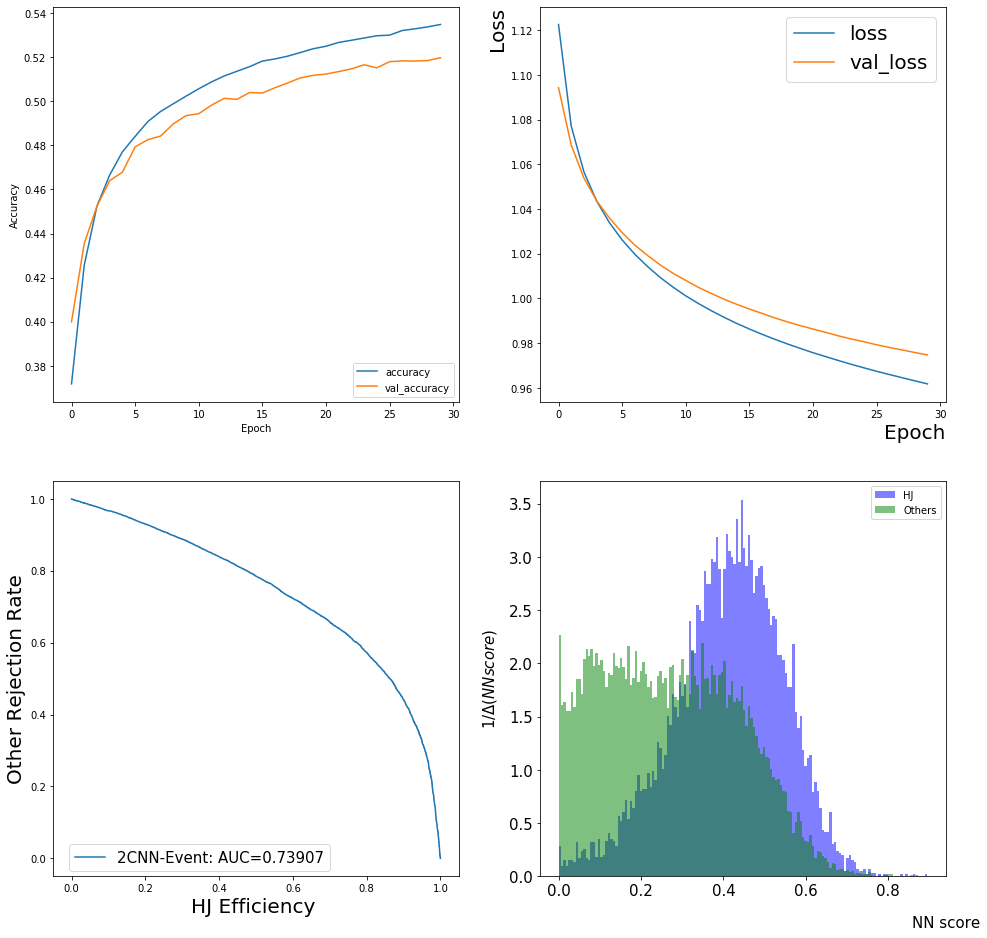

loss: 0.97475
accuracy: 0.51967


In [26]:
axis = 0
if axis == 0:
    process = "HJ"
elif axis == 1:
    process = "VBF"
elif axis == 2:
    process = "VH"
    
prediction = model_jet.predict(x_test_jet)

test_auc = metrics.roc_auc_score(y_test[:,axis],prediction[:,axis])

FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test[:,axis],prediction[:,axis])

plt.figure(figsize=(16,16))
plt.subplot(2,2,1)

plt.plot(history_event_only.history['accuracy'], label='accuracy')
plt.plot(history_event_only.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.subplot(2,2,2)
plt.plot(history_event_only.history['loss'], label='loss')
plt.plot(history_event_only.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch', fontsize=20, horizontalalignment='right',x=1)
plt.ylabel('Loss', fontsize=20, horizontalalignment='right',y=1)
# plt.ylim([0.5, 1])
plt.legend(fontsize=20)#,loc='lower right')

plt.subplot(2,2,3)
plt.plot(TruePositiveFull,1-FalsePositiveFull, label='2CNN-Event: AUC={0:.5f}'.format(test_auc))

plt.ylabel('Other Rejection Rate',fontsize=20)
plt.xlabel(str(process)+' Efficiency ',fontsize=20)
plt.legend(bbox_to_anchor=(0.7, 0.1),ncol=1,fontsize=15)
# plt.tight_layout()

plt.subplot(2,2,4)
Data = pd.DataFrame()
Data["target"] = y_test[:,axis]
Data["pre"] = prediction[:,axis]
inner = Data[Data["target"]==1]
outter = Data[Data["target"]==0]
NNscoreplot = pd.DataFrame({str(process): inner["pre"], 'Others': outter["pre"]}, columns=[str(process), 'Others'])
plot = NNscoreplot.plot( kind = 'hist', title = "", legend = True, bins = 150, alpha=0.5,
                      color=['b','g'],stacked=False,density=1,fontsize=15,ax=plt.gca())

plot.set_ylabel("$1/\Delta (NN score)$",fontsize=15)
plot.set_xlabel("NN score",fontsize=15)
plot.xaxis.set_label_coords(1, -0.1)
plot.yaxis.set_label_coords(-0.1 , 0.5)

# plt.savefig("./Higgs_Pt/ROC", transparent=True)
plt.show()

aaaa = model_jet.evaluate(x_test_jet,  y_test, verbose=0)
print("{}: {:.5f}".format(model_jet.metrics_names[0],aaaa[0]))
print("{}: {:.5f}".format(model_jet.metrics_names[1],aaaa[1]))
# print("{}: {:.5f}".format(model_event.metrics_names[2],aaaa[2])) 

## CNN Network Structure Combined together

In [6]:
input_shape = x_train_eve[0].shape
model_event = Sequential(name = 'Sequential_for_event')
model_event.add(Lambda(return_pad_me(4),
                 input_shape=input_shape, name = 'event'))
model_event.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 data_format='channels_first', name = 'event_2D_1'))
model_event.add(Lambda(return_pad_me(1),
                 input_shape=input_shape, name = 'event_padding_1'))
model_event.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),data_format='channels_first', name = 'event_MaxPooling_1'))
model_event.add(Lambda(return_pad_me(4),input_shape=input_shape, name = 'event_padding_2'))
model_event.add(Conv2D(64, (5, 5), activation='relu',data_format="channels_first", name = 'event_2D_2'))
model_event.add(Lambda(return_pad_me(1),input_shape=input_shape, name = 'event_padding_3'))
model_event.add(MaxPooling2D(pool_size=(2, 2),data_format="channels_first", name = 'event_MaxPooling_2'))
model_event.add(Flatten(name = 'event_flatten'))
model_event.add(Dense(300, activation='relu', name = 'event_dense_1'))

model_event.add(Dropout(0.1))


model_jet = Sequential(name = 'Sequential_for_jet')
model_jet.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                data_format='channels_first',input_shape=input_shape, name = 'jet'))
model_jet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),data_format='channels_first', name = 'jet_MaxPooling_1'))
model_jet.add(Conv2D(64, (5, 5), activation='relu',data_format='channels_first', name = 'jet_2D_1'))
model_jet.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first', name = 'jet_MaxPooling_2'))
model_jet.add(Flatten(name = 'jet_flatten'))
model_jet.add(Dense(300, activation='relu', name = 'jet_dense_1'))

model_jet.add(Dropout(0.1))


mergedOut = Concatenate()([model_event.output,model_jet.output])
# mergedOut = Dense(1, activation='sigmoid')(mergedOut)
mergedOut = Dense(4, activation='softmax')(mergedOut)

newModel = Model([model_event.input,model_jet.input], mergedOut,name = 'Combined')

newModel.summary()

Model: "Combined"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_input (InputLayer)        [(None, 3, 40, 40)]  0                                            
__________________________________________________________________________________________________
event (Lambda)                  (None, 3, 44, 40)    0           event_input[0][0]                
__________________________________________________________________________________________________
event_2D_1 (Conv2D)             (None, 32, 40, 36)   2432        event[0][0]                      
__________________________________________________________________________________________________
event_padding_1 (Lambda)        (None, 32, 41, 36)   0           event_2D_1[0][0]                 
___________________________________________________________________________________________

In [15]:
# time counter
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
ticks_1 = time.time()
############################################################################################################################################################


model_opt = keras.optimizers.Adadelta()

newModel.compile(loss="categorical_crossentropy",#keras.losses.binary_crossentropy
              optimizer=model_opt,
              metrics=['accuracy'])

file_writer = tf.summary.create_file_writer("./2CNN_Model/log_test/metrics")
file_writer.set_as_default()

# def lr_schedule(epoch):
#     """
#     Returns a custom learning rate that decreases as epochs progress.
#     """
#     learning_rate = 1.0
#     if epoch > 5:
#         learning_rate = 0.1
#     if epoch > 10:
#         learning_rate = 0.01
#     if epoch > 50:
#         learning_rate = 0.005

#     tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
#     return learning_rate

check_list=[]
# lr_callback = LearningRateScheduler(lr_schedule, verbose=1)
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.005, cooldown=0, min_lr=0)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./2CNN_Model/log_test",histogram_freq=1)
csv_logger = CSVLogger('./2CNN_Model/training_log.csv')
checkpoint = ModelCheckpoint(
        filepath='./2CNN_Model/checkmodel.h5',
        save_best_only=True,
        verbose=1)

check_list.append(tensorboard_callback)
check_list.append(checkpoint)
check_list.append(csv_logger)
# check_list.append(lr_callback)
# check_list.append(EarlyStopping(monitor="highest_SIC_metric", patience=2))


history = newModel.fit([x_train_eve, x_train_jet], y_train,
            batch_size = 512, #50,
            epochs = 20, #50 #10,
            verbose = 1, 
            shuffle = True, 
            validation_data=([x_val_eve, x_val_jet],y_val),
#             validation_split = 0.05,
#            class_weight = {0.008036,0.01057,0.01494},
#             sample_weight = sample_weight,
            callbacks=check_list
            )

newModel.save("./2CNN_Model/model.h5")

# tf.summary.scalar('my learning rate',history.history['lr'])

# tf.summary.scalar('my learning rate', my_learning_rate)
# tf.summary.image('my image', x_train_eve)

############################################################################################################################################################
ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

Fri May 22 15:27:49 2020
Train on 400000 samples, validate on 100000 samples
Epoch 1/20
399872/400000 [============================>.] - ETA: 0s - loss: 0.6902 - accuracy: 0.7297
Epoch 00001: val_loss improved from inf to 0.69052, saving model to ./2CNN_Model/checkmodel.h5
400000/400000 [==============================] - 43s 108us/sample - loss: 0.6902 - accuracy: 0.7297 - val_loss: 0.6905 - val_accuracy: 0.7318
Epoch 2/20
399360/400000 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.7302
Epoch 00002: val_loss improved from 0.69052 to 0.68971, saving model to ./2CNN_Model/checkmodel.h5
400000/400000 [==============================] - 30s 76us/sample - loss: 0.6892 - accuracy: 0.7302 - val_loss: 0.6897 - val_accuracy: 0.7325
Epoch 3/20
399360/400000 [============================>.] - ETA: 0s - loss: 0.6886 - accuracy: 0.7308
Epoch 00003: val_loss improved from 0.68971 to 0.68926, saving model to ./2CNN_Model/checkmodel.h5
400000/400000 [==========================

In [7]:
newModel = load_model("./2CNN_Model/model.h5")
training_log = pd.read_csv("./2CNN_Model/training_log.csv")

In [5]:
confusion = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(newModel.predict([x_test_eve, x_test_jet]), axis=1))
print(confusion)
ratio, eff = np.zeros(16), np.zeros(16)
k = 0
for i in range(4):
    for j in range(4):
        ratio[k] = (confusion[j][i]/np.sum(confusion,axis=0)[i])*100.
        eff[k] = (confusion[j][i]/np.sum(confusion,axis=1)[i])*100.
        k += 1

print("{:^8}  {:^8} {:^8} {:^8} {:^9} {:^9} {:^9} {:^9} {:^9}".format("","ggH ratio","VBF ratio","VH ratio","ttH ratio","ggH eff.","VBF eff.","VH eff.","ttH eff."))
print("{:^8}  {:^8.2f} {:^8.2f} {:^8.2f} {:^9.2f} {:^9.2f} {:^9.2f} {:^9.2f} {:^9.2f}".format("ggH-like",ratio[0],ratio[1],ratio[2],ratio[3],eff[0],eff[1],eff[2],eff[3]))
print("{:^8}  {:^8.2f} {:^8.2f} {:^8.2f} {:^9.2f} {:^9.2f} {:^9.2f} {:^9.2f} {:^9.2f}".format("VBF-like",ratio[4],ratio[5],ratio[6],ratio[7],eff[4],eff[5],eff[6],eff[7]))
print("{:^8}  {:^8.2f} {:^8.2f} {:^8.2f} {:^9.2f} {:^9.2f} {:^9.2f} {:^9.2f} {:^9.2f}".format("VH-like",ratio[8],ratio[9],ratio[10],ratio[11],eff[8],eff[9],eff[10],eff[11]))
print("{:^8}  {:^8.2f} {:^8.2f} {:^8.2f} {:^9.2f} {:^9.2f} {:^9.2f} {:^9.2f} {:^9.2f}".format("ttH-like",ratio[12],ratio[13],ratio[14],ratio[15],eff[12],eff[13],eff[14],eff[15]))

[[15506  2879  2860  3755]
 [ 2722 20122  1644   512]
 [ 3175  1353 17718  2754]
 [ 2465   381  1749 20405]]
          ggH ratio VBF ratio VH ratio ttH ratio ggH eff.  VBF eff.   VH eff.  ttH eff. 
ggH-like   64.97    11.40    13.30     10.33     62.02     10.89     12.70     9.86   
VBF-like   11.64    81.35     5.47     1.54      11.52     80.49     5.41      1.52   
VH-like    11.93     6.86    73.91     7.30      11.44     6.58      70.87     7.00   
ttH-like   13.69     1.87    10.04     74.40     15.02     2.05      11.02     81.62  


train: 0.875 test: 0.866


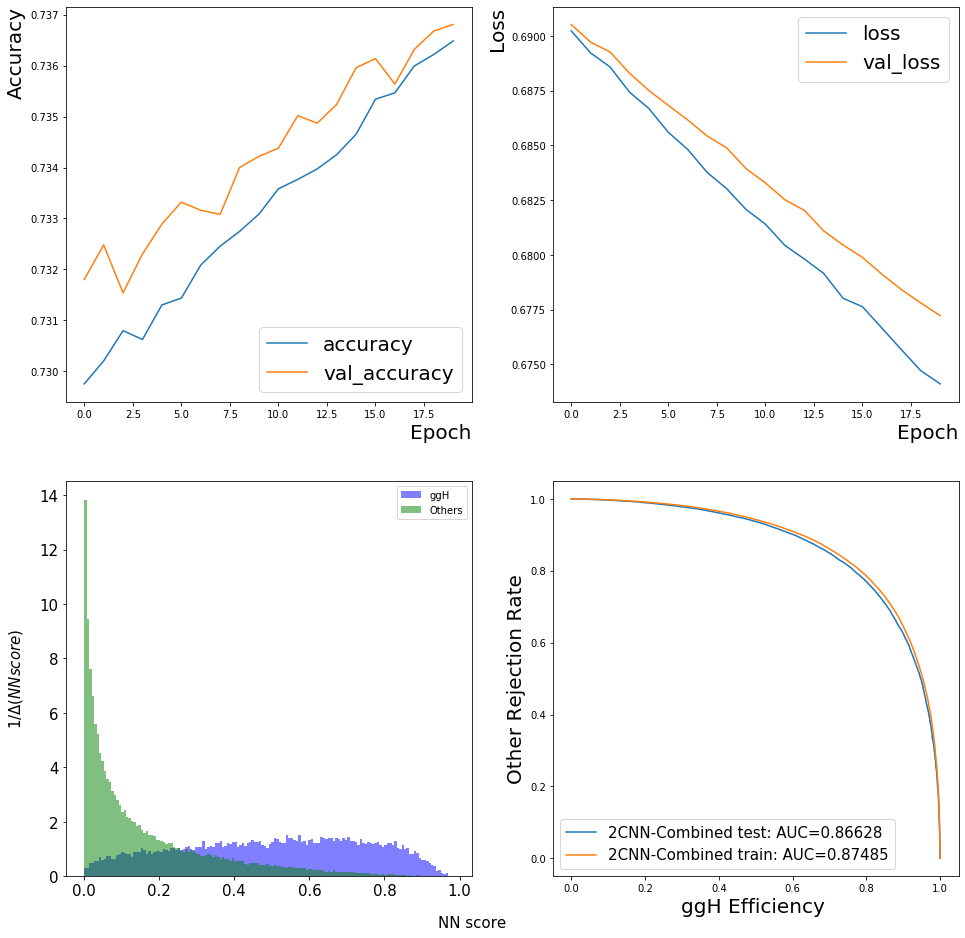

In [13]:
axis = 0
if axis == 0:
    process = "ggH"
elif axis == 1:
    process = "VBF"
elif axis == 2:
    process = "VH"
elif axis == 3:
    process = "ttH"

prediction_train = newModel.predict([x_train_eve, x_train_jet])
prediction_test = newModel.predict([x_test_eve, x_test_jet])
Data_test["2CNN_Prediction"] = prediction_test[:,axis]

#save the prediction to 2CNN_Model
Data_test.to_csv("./2CNN_Model/Data_test.csv",index = 0)
np.save("./2CNN_Model/prediction_2CNN", prediction_test)


test_auc_train = metrics.roc_auc_score(y_train[:,axis],prediction_train[:,axis])
test_auc_test = metrics.roc_auc_score(y_test[:,axis],prediction_test[:,axis])
print("train: {:.3f} test: {:.3f}".format(test_auc_train,test_auc_test))

FalsePositiveFull_train, TruePositiveFull_train, ThresholdFull_train = metrics.roc_curve(y_train[:,axis],prediction_train[:,axis])
FalsePositiveFull_test, TruePositiveFull_test, ThresholdFull_test = metrics.roc_curve(y_test[:,axis],prediction_test[:,axis])


plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.plot(training_log['accuracy'], label='accuracy')
plt.plot(training_log['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize=20, horizontalalignment='right',x=1)
plt.ylabel('Accuracy', fontsize=20, horizontalalignment='right',y=1)
# plt.ylim([0.5, 1])
plt.legend(loc='lower right',fontsize=20)

plt.subplot(2,2,2)
plt.plot(training_log['loss'], label='loss')
plt.plot(training_log['val_loss'], label = 'val_loss')
plt.xlabel('Epoch', fontsize=20, horizontalalignment='right',x=1)
plt.ylabel('Loss', fontsize=20, horizontalalignment='right',y=1)
# plt.ylim([0.5, 1])
plt.legend(fontsize=20)#,loc='lower right')


plt.subplot(2,2,3)
Data = pd.DataFrame()
Data["target"] = y_test[:,axis]
Data["pre"] = prediction_test[:,axis]
inner = Data[Data["target"]==1]
outter = Data[Data["target"]==0]
NNscoreplot = pd.DataFrame({str(process): inner["pre"], 'Others': outter["pre"]}, columns=[str(process), 'Others'])
plot = NNscoreplot.plot( kind = 'hist', title = "", legend = True, bins = 150, alpha=0.5,
                      color=['b','g'],stacked=False,density=1,fontsize=15,ax=plt.gca())

plot.set_ylabel("$1/\Delta (NN score)$",fontsize=15)
plot.set_xlabel("NN score",fontsize=15)
plot.xaxis.set_label_coords(1, -0.1)
plot.yaxis.set_label_coords(-0.1 , 0.5)

plt.subplot(2,2,4)
plt.plot(TruePositiveFull_test,1-FalsePositiveFull_test, label='2CNN-Combined test: AUC={0:.5f}'.format(test_auc_test))
plt.plot(TruePositiveFull_train,1-FalsePositiveFull_train, label='2CNN-Combined train: AUC={0:.5f}'.format(test_auc_train))

plt.ylabel('Other Rejection Rate',fontsize=20)
plt.xlabel(str(process)+' Efficiency ',fontsize=20)
plt.legend(ncol=1,fontsize=15)  #bbox_to_anchor=(0.7, 0.1)
# plt.tight_layout()

# plt.savefig("./Higgs_Pt/ROC", transparent=True)
# plt.show()


# plt.legend(bbox_to_anchor=(1, 1),ncol=1,fontsize=15)
# plt.savefig("./Higgs_Pt/BDT_score", transparent=True)
plt.show()

## The Diagram below is HJ v.s. VBF

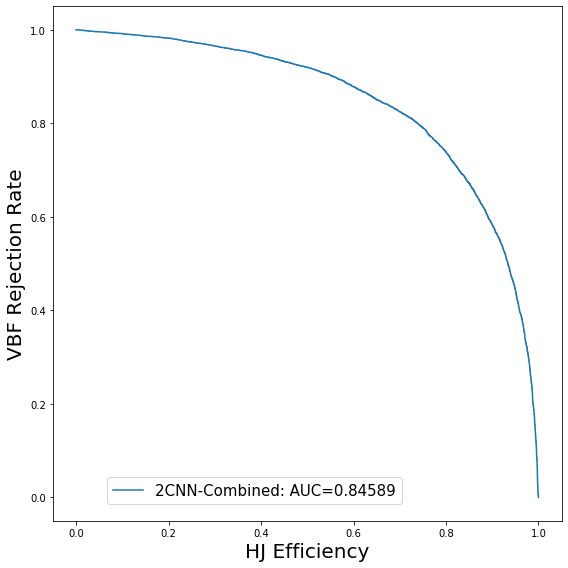

In [68]:
prediction = newModel.predict([x_test_eve, x_test_jet])

test_auc = metrics.roc_auc_score(y_test[:],prediction[:])

# HJ label to 0, it will become to "fpr" from metrics.roc_curve()
FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test[:],prediction[:])
#False to Negative means HJ Efficiency!!

plt.figure(figsize=(8,8))

plt.plot(1-FalsePositiveFull,TruePositiveFull, label='2CNN-Combined: AUC={0:.5f}'.format(test_auc))

plt.ylabel("VBF Rejection Rate",fontsize=20)
plt.xlabel("HJ Efficiency",fontsize=20)
plt.legend(bbox_to_anchor=(0.7, 0.1),ncol=1,fontsize=15)
plt.tight_layout()

# plt.savefig("./Higgs_Pt/ROC", transparent=True)
plt.show()

In [ ]:
# %tensorboard --logdir ./Model/log_test

In [ ]:
# class My_Custom_Generator(keras.utils.Sequence) :
  
#   def __init__(self, image_filenames, labels, batch_size) :
#     self.image_filenames = image_filenames
#     self.labels = labels
#     self.batch_size = batch_size
    
    
#   def __len__(self) :
#     return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
#   def __getitem__(self, idx) :
#     batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
#     batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
#     return np.array([
#             resize(imread('/content/all_images/' + str(file_name)), (80, 80, 3))
#                for file_name in batch_x])/255.0, np.array(batch_y)


# batch_size = 32

# my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size)
# my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size)



# model.fit(generator=my_training_batch_generator,
#                    steps_per_epoch = int(3800 // batch_size),
#                    epochs = 10,
#                    verbose = 1,
#                    validation_data = my_validation_batch_generator,
#                    validation_steps = int(950 // batch_size))

In [16]:
# training_log_0 = pd.read_csv("./2CNN_Model_0/training_log.csv")
training_log_0 = pd.read_csv("./2CNN_Model_1/training_log.csv")
training_log_1 = pd.read_csv("./2CNN_Model/training_log.csv")

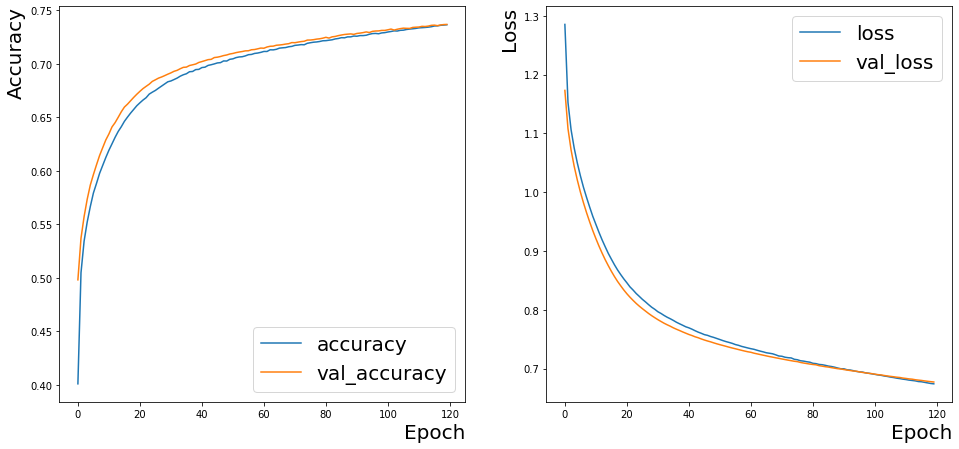

In [17]:
training_log = pd.concat([training_log_0,training_log_1],ignore_index=True,axis=0,join='inner')

plt.figure(figsize=(16,16))

plt.subplot(2,2,1)
plt.plot(training_log['accuracy'], label='accuracy')
plt.plot(training_log['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch', fontsize=20, horizontalalignment='right',x=1)
plt.ylabel('Accuracy', fontsize=20, horizontalalignment='right',y=1)
# plt.ylim([0.5, 1])
plt.legend(loc='lower right',fontsize=20)

plt.subplot(2,2,2)
plt.plot(training_log['loss'], label='loss')
plt.plot(training_log['val_loss'], label = 'val_loss')
plt.xlabel('Epoch', fontsize=20, horizontalalignment='right',x=1)
plt.ylabel('Loss', fontsize=20, horizontalalignment='right',y=1)
# plt.ylim([0.5, 1])
plt.legend(fontsize=20)#,loc='lower right')


plt.show()